In [ ]:
# so we can use packages from parent directory
import sys
sys.path.append("..")

In [158]:
import torch
import torch.nn as nn
import numpy as np
from monroe_data import MonroeData, MonroeDataEntry, Color # last two for reading pkl file
from caption_featurizers import CaptionFeaturizer
from color_featurizers import ColorFeaturizer, color_phi_fourier

import time
import math

In [156]:
import color_featurizers

In [157]:
importlib.reload(color_featurizers)

<module 'color_featurizers' from '/Users/benjaminnewman/Documents/Stanford/Freshman_2017-2018/WINTER/LINGUIST130A/linguist-130a-final-proj/color_featurizers.py'>

In [136]:
class MonroeExperiment:
    
    def __init__(self, train_data, test_data, featurizers, model, optimizer=torch.optim.Adadelta,
                 criterion=nn.NLLLoss, lr=0.2, num_epochs=50):
        self.train_data = train_data
        self.test_data = test_data
        self.caption_featurizer = featurizers['caption']
        self.color_featurizer = featurizers['color']
        self.model = model
        
        self.optimizer = optimizer
        self.criterion = criterion
        
        # misc args:
        self.lr = 0.2
        self.num_epochs = num_epochs
        
        # for reproducibility, store training pairs
        self.train_pairs = None
    
    def train_iter(self, caption_tensor, color_tensor, target, optimizer, criterion):
        start_states = self.model.init_hidden_and_context()
        input_length = caption_tensor.size(0)
        optimizer.zero_grad()
        loss = 0

        model_output, _, _ = self.model(caption_tensor, start_states, color_tensor)
        model_output = model_output.view(1, -1)

        loss += criterion(model_output, target)
        loss.backward()
        optimizer.step()

        return loss
    
    def get_pairs(self, data, construct=False):
        # create pairs (caption, colors, target)
        pairs = []
        for entry in data:
            caption_features = self.caption_featurizer.to_tensor(entry.caption, construct=construct)
            color_features = self.color_featurizer.to_tensor(entry.colors)
            color_features, target = self.color_featurizer.shuffle_colors(color_features)
            
            pairs.append((caption_features, color_features, target))
        
        return pairs
            
    # from https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
    def asMinutes(self, s):
        m = math.floor(s / 60)
        s -= m * 60
        return '%dm %ds' % (m, s)  
    
    
    def init_model(self, **model_params):
        self.caption_featurizer.construct_featurizer(self.train_data)
        self.train_pairs = self.get_pairs(self.train_data, construct=True)
        model_params['vocab_size'] = self.caption_featurizer.caption_indexer.size
        self.model = self.model(**model_params)
            
    def train_model(self):
        # training pairs should have already been created by calling init model
        

        optimizer = self.optimizer(lr=self.lr,params=self.model.parameters())
        criterion = self.criterion()
        
        start_time = time.time()
        store_losses_every = 100
        print_losses_every = 1000
        self.stored_losses = []
        for epoch in range(self.num_epochs):
            print("---EPOCH {}---".format(epoch))
            stored_loss_total = 0
            print_loss_total = 0

            for i, pair in enumerate(self.train_pairs):
                caption, colors, target = pair
                # print(target)

                loss = self.train_iter(caption, colors, target, optimizer, criterion)
                stored_loss_total += loss.item()
                print_loss_total += loss.item()

                if i % print_losses_every == 0:
                    print_loss_avg = print_loss_total / print_losses_every
                    print("{} ({}:{} {:.2f}%) {:.4f}".format(self.asMinutes(time.time() - start_time),
                                                      epoch, i, i/len(self.train_pairs)*100,
                                                      print_loss_avg))
                    print_loss_total = 0

                if i % store_losses_every == 0:
                    stored_loss_avg = stored_loss_total / store_losses_every
                    self.stored_losses.append(stored_loss_avg)
                    stored_loss_total = 0
                    
                    
    def evaluate_iter(self, pair):
        with torch.no_grad():
            caption_tensor, color_tensor, target = pair
            start_states = self.model.init_hidden_and_context()
            model_output, _, _ = self.model(caption_tensor, start_states, color_tensor)

            model_output = model_output.view(1, -1)
            if torch.argmax(model_output).item() == target.item():
                return 1, model_output
            else:
                return 0, model_output

              
    def evaluate_model(self):
        """
        Evaluate model accuracy
        """
        test_pairs = self.get_pairs(self.test_data)
        self.model.eval()
        
        total_correct = 0
        for pair in test_pairs:
            correct, _ = self.evaluate_iter(pair) 
            total_correct += correct
            
        accuracy = total_correct/len(self.test_data)
        print("Accuracy: {}".format(accuracy))
        return accuracy
        
        

In [152]:
train_data = MonroeData("train_corpus_monroe.csv", "train_entries_monroe.pkl")
dev_data = MonroeData("dev_corpus_monroe.csv", "dev_entries_monroe.pkl")

In [164]:
caption_phi = CaptionFeaturizer()
color_phi = ColorFeaturizer(color_phi_fourier, "rgb")

In [143]:
experiment_one = MonroeExperiment(train_data, dev_data, {'caption':caption_phi, 'color':color_phi}, CaptionEncoder)

In [144]:
experiment_one.init_model(embed_dim = 100, hidden_dim=100, color_dim=3, color_in_dim=3)

In [145]:
experiment_one.train_model()

---EPOCH 0---
0m 0s (0:0 0.00%) 0.0030
0m 5s (0:1000 6.38%) 1.1018
0m 12s (0:2000 12.77%) 1.0692
0m 18s (0:3000 19.15%) 1.0644
0m 26s (0:4000 25.53%) 1.0571
0m 34s (0:5000 31.92%) 1.0703
0m 41s (0:6000 38.30%) 1.0665
0m 48s (0:7000 44.69%) 1.0629
0m 55s (0:8000 51.07%) 1.0790
1m 3s (0:9000 57.45%) 1.0433
1m 10s (0:10000 63.84%) 1.0727
1m 17s (0:11000 70.22%) 1.0300
1m 24s (0:12000 76.60%) 1.0613
1m 32s (0:13000 82.99%) 1.0486
1m 39s (0:14000 89.37%) 1.0364
1m 46s (0:15000 95.75%) 1.0535
---EPOCH 1---
1m 51s (1:0 0.00%) 0.0013
1m 58s (1:1000 6.38%) 1.0385
2m 6s (1:2000 12.77%) 1.0376
2m 13s (1:3000 19.15%) 1.0332
2m 21s (1:4000 25.53%) 1.0485
2m 28s (1:5000 31.92%) 1.0505
2m 35s (1:6000 38.30%) 1.0639
2m 42s (1:7000 44.69%) 1.0497
2m 49s (1:8000 51.07%) 1.0638
2m 56s (1:9000 57.45%) 1.0359
3m 3s (1:10000 63.84%) 1.0687
3m 10s (1:11000 70.22%) 1.0222
3m 17s (1:12000 76.60%) 1.0578
3m 24s (1:13000 82.99%) 1.0436
3m 31s (1:14000 89.37%) 1.0299
3m 38s (1:15000 95.75%) 1.0429
---EPOCH 2---
3

29m 50s (16:1000 6.38%) 0.8165
29m 57s (16:2000 12.77%) 0.7513
30m 5s (16:3000 19.15%) 0.7124
30m 12s (16:4000 25.53%) 0.7434
30m 19s (16:5000 31.92%) 0.7524
30m 27s (16:6000 38.30%) 0.7700
30m 34s (16:7000 44.69%) 0.8644
30m 41s (16:8000 51.07%) 0.8077
30m 48s (16:9000 57.45%) 0.8145
30m 55s (16:10000 63.84%) 0.8299
31m 1s (16:11000 70.22%) 0.8863
31m 8s (16:12000 76.60%) 0.9215
31m 15s (16:13000 82.99%) 0.8431
31m 22s (16:14000 89.37%) 0.8008
31m 30s (16:15000 95.75%) 0.7938
---EPOCH 17---
31m 35s (17:0 0.00%) 0.0002
31m 41s (17:1000 6.38%) 0.8146
31m 49s (17:2000 12.77%) 0.7305
31m 56s (17:3000 19.15%) 0.7029
32m 4s (17:4000 25.53%) 0.7357
32m 11s (17:5000 31.92%) 0.7278
32m 18s (17:6000 38.30%) 0.7596
32m 25s (17:7000 44.69%) 0.8764
32m 32s (17:8000 51.07%) 0.8166
32m 39s (17:9000 57.45%) 0.8041
32m 46s (17:10000 63.84%) 0.8458
32m 53s (17:11000 70.22%) 0.8743
33m 0s (17:12000 76.60%) 0.9072
33m 7s (17:13000 82.99%) 0.8330
33m 14s (17:14000 89.37%) 0.7967
33m 21s (17:15000 95.75%) 

In [146]:
experiment_one.evaluate_model()

Accuracy: 0.4278876834716018


0.4278876834716018

In [201]:
experiment_fourier = MonroeExperiment(train_data, dev_data, {'caption':caption_phi, 'color':color_phi}, CaptionEncoder)
experiment_fourier.init_model(embed_dim = 100, hidden_dim=100, color_dim=54)


In [194]:
experiment_fourier.train_model()

---EPOCH 0---
0m 0s (0:0 0.00%) 0.0000
0m 9s (0:1000 6.38%) 1.2183
0m 21s (0:2000 12.77%) 0.9420
0m 34s (0:3000 19.15%) 0.9296
0m 47s (0:4000 25.53%) 0.8703
1m 0s (0:5000 31.92%) 0.9012
1m 12s (0:6000 38.30%) 0.6950
1m 24s (0:7000 44.69%) 0.6041
1m 36s (0:8000 51.07%) 0.7501
1m 48s (0:9000 57.45%) 0.5791
2m 0s (0:10000 63.84%) 0.5544
2m 12s (0:11000 70.22%) 0.5353
2m 23s (0:12000 76.60%) 0.5876
2m 35s (0:13000 82.99%) 0.5593
2m 47s (0:14000 89.37%) 0.5501
2m 59s (0:15000 95.75%) 0.6513
---EPOCH 1---
3m 7s (1:0 0.00%) 0.0002
3m 19s (1:1000 6.38%) 0.4782
3m 31s (1:2000 12.77%) 0.6165
3m 44s (1:3000 19.15%) 0.6661
3m 56s (1:4000 25.53%) 0.6993
4m 8s (1:5000 31.92%) 0.6792
4m 20s (1:6000 38.30%) 0.5174
4m 32s (1:7000 44.69%) 0.4664
4m 45s (1:8000 51.07%) 0.6080
4m 56s (1:9000 57.45%) 0.4867
5m 9s (1:10000 63.84%) 0.4236
5m 21s (1:11000 70.22%) 0.4912
5m 33s (1:12000 76.60%) 0.5301
5m 45s (1:13000 82.99%) 0.4813
5m 57s (1:14000 89.37%) 0.4497
6m 10s (1:15000 95.75%) 0.6017
---EPOCH 2---
6m 

69m 5s (16:1000 6.38%) 0.2506
69m 24s (16:2000 12.77%) 0.2469
69m 43s (16:3000 19.15%) 0.3226
70m 1s (16:4000 25.53%) 0.3052
70m 20s (16:5000 31.92%) 0.2369
70m 42s (16:6000 38.30%) 0.2286
71m 2s (16:7000 44.69%) 0.1795
71m 22s (16:8000 51.07%) 0.1953
71m 43s (16:9000 57.45%) 0.2807
72m 3s (16:10000 63.84%) 0.2043
72m 23s (16:11000 70.22%) 0.3101
72m 42s (16:12000 76.60%) 0.3855
73m 1s (16:13000 82.99%) 0.2297
73m 24s (16:14000 89.37%) 0.2221
73m 43s (16:15000 95.75%) 0.2496
---EPOCH 17---
73m 58s (17:0 0.00%) 0.0000
74m 18s (17:1000 6.38%) 0.2818
74m 39s (17:2000 12.77%) 0.2400
74m 59s (17:3000 19.15%) 0.2155
75m 21s (17:4000 25.53%) 0.2434
75m 41s (17:5000 31.92%) 0.2829
76m 3s (17:6000 38.30%) 0.1375
76m 24s (17:7000 44.69%) 0.2091
76m 44s (17:8000 51.07%) 0.1972
77m 5s (17:9000 57.45%) 0.2673
77m 26s (17:10000 63.84%) 0.1345
77m 48s (17:11000 70.22%) 0.2853
78m 7s (17:12000 76.60%) 0.3780
78m 27s (17:13000 82.99%) 0.2206
78m 49s (17:14000 89.37%) 0.2352
79m 9s (17:15000 95.75%) 0.2

In [195]:
experiment_fourier.evaluate_model()

Accuracy: 0.7991703892788768


0.7991703892788768

In [196]:
torch.save(experiment_fourier.model.state_dict(), "literal_listener.params")

In [202]:
caption_phi_copy = CaptionFeaturizer()
color_phi_copy = ColorFeaturizer(color_phi_fourier, "rgb")

In [203]:
experiment_fourier_copy = MonroeExperiment(train_data, dev_data, {'caption':caption_phi_copy, 'color':color_phi_copy}, CaptionEncoder)

In [204]:
experiment_fourier_copy.init_model(embed_dim = 100, hidden_dim=100, color_dim=54)

In [205]:
experiment_fourier_copy.model.load_state_dict(torch.load("literal_listener.params"))

In [206]:
experiment_fourier_copy.evaluate_model()

Accuracy: 0.7991703892788768


0.7991703892788768

In [167]:
#caption_tensor, color_tensor, target, optimizer, criterion

optimizer_test = torch.optim.Adadelta(lr=0.2, params=experiment_one.model.parameters())
criterion_test =nn.NLLLoss()

caption_tensor_test = experiment_fourier.caption_featurizer.to_tensor(train_data[0].caption)
color_tensor_test = experiment_fourier.color_featurizer.to_tensor(train_data[0].colors)
target_test = torch.tensor([0])

#experiment_one.train_iter()

In [169]:
experiment_fourier.train_iter(caption_tensor_test, color_tensor_test, target_test, optimizer_test, criterion_test)

RuntimeError: The size of tensor a (3) must match the size of tensor b (54) at non-singleton dimension 1

In [112]:
color_tensor_test

tensor([[0.0938, 0.2852, 0.9062],
        [0.6875, 0.0664, 0.9336],
        [0.1641, 0.0391, 0.9609]])

In [180]:
experiment_fourier.model = CaptionEncoder(embed_dim = 100, hidden_dim=100, vocab_size=experiment_one.caption_featurizer.caption_indexer.size, color_dim=54)

In [181]:
experiment_fourier.train_iter(caption_tensor_test, color_tensor_test, target_test, optimizer_test, criterion_test)

color shape: torch.Size([3, 54])
mean shape: torch.Size([3, 54])
scores shape (1): torch.Size([3, 54])
scores shape (2): torch.Size([3, 3])
final distribution shape: torch.Size([3])


tensor(1.0844, grad_fn=<AddBackward0>)

In [173]:
random_tensor = torch.tensor([[1, 2, 3], 
                              [4, 5, 6]])

In [178]:
random_tensor

tensor([[1, 2, 3],
        [4, 5, 6]])

In [186]:
other_tensor = torch.tensor([[1, 2, 3], 
                            [1, 2, 1], 
                            [1, 2, 1]])

In [187]:
other_tensor

tensor([[1, 2, 3],
        [1, 2, 1],
        [1, 2, 1]])

In [188]:
torch.matmul(other_tensor, random_tensor)

RuntimeError: size mismatch, m1: [3 x 3], m2: [2 x 3] at /Users/administrator/nightlies/pytorch-1.0.0/wheel_build_dirs/wheel_3.6/pytorch/aten/src/TH/generic/THTensorMath.cpp:940

In [185]:
torch.matmul(random_tensor, torch.tensor([1, 2, 3]))

tensor([14, 32])

In [175]:
random_tensor.shape

torch.Size([2, 3])

In [114]:
experiment_one.evaluate_model()

Accuracy: 0.3281429483088705


0.3281429483088705

In [80]:
train_data[0].colors[0].rgb_norm

[0.09375, 0.28515625, 0.90625]

In [13]:
embed_dim = 100
hidden_dim = 100
color_dim = 3
color_in_dim = 3

model = CaptionEncoder(embed_dim, hidden_dim, color_in_dim, color_dim)

,gameid,clkTime,roundNum,condition,clickStatus,clickColH,clickColS,clickColL,clickLocS,clickLocL,...,msgTime,role,contents,workerid_uniq,numOutcome,numRawWords,numRawChars,numCleanChars,numCleanWords,source
0,2641-2,1.476490e+12,1,split,target,48,13,50,2,1,...,1.476490e+12,speaker,gray,619.0,1.0,1,4,4.0,1.0,human


In [192]:
class CaptionEncoder(nn.Module):
    
    def __init__(self, embed_dim, hidden_dim, vocab_size, color_dim, **misc_params):
        """
        embed_dim = hidden_dim = 100
        
        All the options can be found here: https://github.com/futurulus/colors-in-context/blob/master/models/l0.config.json
        """
        super(CaptionEncoder, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        
        # should initialize bias to 0: https://github.com/futurulus/colors-in-context/blob/2e7b830668cd039830154e7e8f211c6d4415d30f/listener.py#L383
        
        # √ he also DOESN'T use dropout for the base listener 
        
        # also non-linearity is "leaky_rectify" - I can't implement this without rewriting lstm :(, so I'm just going
        # to hope this isn't a problem
        
        # √ also LSTM is bidirectional (https://github.com/futurulus/colors-in-context/blob/2e7b830668cd039830154e7e8f211c6d4415d30f/listener.py#L713)

        self.lstm = nn.LSTM(embed_dim, hidden_dim, bidirectional=True)
        
        self.mean = nn.Linear(2*hidden_dim, color_dim)
        # covariance matrix is square, so we initialize it with color_dim^2 dimensions
        # we also initialize the bias to be the identity
        covar_dim = color_dim*color_dim
        self.covariance = nn.Linear(2*hidden_dim, covar_dim)
        self.covariance.bias.data = torch.tensor(np.eye(color_dim), dtype=torch.float).flatten()
        self.logsoftmax = nn.LogSoftmax(dim=0)

        self.color_dim = color_dim
        self.hidden_dim = hidden_dim
        
    def forward(self, caption, states, colors):
        embeddings = self.embed(caption)
        output, (hn, cn) = self.lstm(embeddings, states)
        
        # we only care about last output
        output = output[-1].view(1, -1)
        
        output_mean = self.mean(output)[0]
        output_covariance = self.covariance(output)[0]
        covar_matrix = output_covariance.reshape(-1, self.color_dim) # make it a square matrix again
        
        
        # now compute score: -(f-mu)^T Sigma (f-mu)
        # colors = colors.transpose(0, 1)
        # print("color shape:", colors.shape)
        output_mean = output_mean.repeat(3,1)
        # print("mean shape:", output_mean.shape)
        diff_from_mean = colors - output_mean
        scores = torch.matmul(diff_from_mean, covar_matrix)
        #print("scores shape (1):", scores.shape) # expecting 3x54
        scores = torch.matmul(scores, diff_from_mean.transpose(0,1))
        #print("scores shape (2):", scores.shape) # expecting 3x3
        scores = -torch.diag(scores)
        distribution = self.logsoftmax(scores)
        #print("final distribution shape:", distribution.shape) # expecting 3x1
        return distribution, output_mean, covar_matrix
    
    def init_hidden_and_context(self):
        # first 2 for each direction
        return (torch.zeros(2, 1, self.hidden_dim),
                torch.zeros(2, 1, self.hidden_dim))
        

In [147]:
dev_data[3014]

drab green not the bluer one

In [148]:
import matplotlib

In [149]:
%matplotlib inline

3014) Game: 0109-c Round: 33
drab green not the bluer one


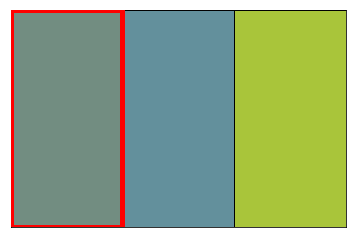

In [150]:
dev_data.display_game(3014)

In [151]:
train_data.data.head()

,gameid,clkTime,roundNum,condition,clickStatus,clickColH,clickColS,clickColL,clickLocS,clickLocL,...,msgTime,role,contents,workerid_uniq,numOutcome,numRawWords,numRawChars,numCleanChars,numCleanWords,source
0,1124-1,1.459877e+12,1,close,distr2,248,92,50,3,1,...,1.459877e+12,speaker,The darker blue one,201.0,0.0,4,16,13.0,3.0,human
1,1124-1,1.459877e+12,2,far,target,249,25,50,1,2,...,1.459877e+12,speaker,purple,201.0,1.0,1,6,6.0,1.0,human
2,1124-1,1.459877e+12,3,close,distr2,291,59,50,3,3,...,1.459877e+12,speaker,Medium pink the medium dark one,201.0,0.0,4,16,13.0,3.0,human
3,1124-1,1.459877e+12,4,split,distr1,85,21,50,2,1,...,1.459877e+12,speaker,lime,201.0,0.0,1,4,4.0,1.0,human
4,1124-1,1.459877e+12,5,far,target,156,84,50,1,3,...,1.459877e+12,speaker,Mint green.,201.0,1.0,2,9,9.0,2.0,human
